In [1]:
# import pandas as pd

# # Define the questions and labels
# questions = [
#     "Are you Happy?",
#     "Do you feel interest or pleasure in doing things?",
#     "Do you feel generally at ease with yourself and your surroundings?",
#     "Do you find it easy to relax in most situations?",
#     "Do you feel refreshed after a night's sleep?",
#     "Do you often feel empty or hopeless?",
#     "Do you have thoughts of harming yourself or ending your life?",
#     "Do you often feel worthless?",
#     "Thoughts that you would be better off dead?",
#     "Feeling bad about yourself or that you are a failure or have let yourself or your family down?",
#     "Do you frequently feel sad or hopeless?",
#     "Do you often feel mentally foggy or forgetful?",
#     "Do you struggle to start or complete tasks that require effort?",
#     "Have you experienced a significant change in your appetite?",
#     "Do you experience frequent mood swings?",
#     "Do you often wake up feeling tired or unrested?",
#     "Do you have trouble relaxing at the end of the day?",
#     "Do you frequently feel fatigued or lacking in energy?"
# ]
# labels = [
#     "Normal", "Normal", "Normal", "Normal", "Normal",
#     "Depression", "Depression", "Depression", "Depression", "Depression", "Depression",
#     "Stressed", "Stressed", "Stressed", "Stressed", "Stressed", "Stressed", "Stressed"
# ]

# # Create a DataFrame
# data = pd.DataFrame({"Question": questions, "Label": labels})

# # Save the DataFrame to a CSV file
# data.to_csv("mental_state_dataset.csv", index=False)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('/content/drive/MyDrive/finals.csv',encoding="latin1")

In [5]:
data.head()

,S.No.,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,Labels
0,0,6.380000e+17,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1.013187e+09,84.0,211.0,251.0,837.0,0.0,Depression
1,1,6.380000e+17,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1.013187e+09,84.0,211.0,251.0,837.0,1.0,Depression
2,2,6.380000e+17,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1.013187e+09,84.0,211.0,251.0,837.0,0.0,Depression
3,3,6.380000e+17,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1.013187e+09,84.0,211.0,251.0,837.0,2.0,Depression
4,4,6.380000e+17,Sat Aug 29 18:40:26 +0000 2015,Itâs hard to say whether packing lists are m...,1.013187e+09,84.0,211.0,251.0,837.0,1.0,Depression


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(post_text):
    if isinstance(post_text, str):
        # Remove URLs
        text = re.sub(r'https?://\S+', '', post_text)

        # Remove non-alphabetical or symbol words
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Convert to lowercase
        text = text.lower()

        # Tokenization of the text
        tokens = word_tokenize(text)

        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

        # Joining tokens into a single string
        processed_text = ' '.join(lemmatized_tokens)
        return processed_text
    else:
        return ""

# Apply preprocessing to 'post_text' column
data['Processed_Text'] = data['post_text'].apply(preprocess_text)

# Remove Duplicates based on the processed text
data.drop_duplicates(subset='Processed_Text', inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
print(data.dtypes)

S.No.              object
post_id           float64
post_created       object
post_text          object
user_id           float64
followers         float64
friends           float64
favourites        float64
statuses          float64
retweets          float64
Labels             object
Processed_Text     object
dtype: object


In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["Labels"] = encoder.fit_transform(data["Labels"])

In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data["Processed_Text"], data["Labels"], test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to a fixed length
max_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Get the number of unique classes
num_classes = len(data["Labels"].unique())

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Adjust the number of output nodes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Train the model
history= model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 100)           2888000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 2968804 (11.33 MB)
Trainable params: 2968804 (11.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
816/816 [==============================] - 133s 159ms/step - loss: 0.9130 - accuracy: 0.5940 - val_loss: 0.9201 - val_accuracy: 0.5918
Epoch 2/5
816/816 [==============================] - 131s 160ms/step - loss: 0.9144 - accuracy: 0.5928 - val_loss: 0.9193 - val_accurac

In [10]:
import pickle

# Save the dictionary to a pickle file
with open('/content/drive/MyDrive/model/lstm.pkl', 'wb') as f:
    pickle.dump(model, f)


In [11]:
with open('/content/drive/MyDrive/model/lstm.pkl', 'rb') as f:
    model_data = pickle.load(f)
    print(model_data)


204/204 [==============================] - 4s 17ms/step


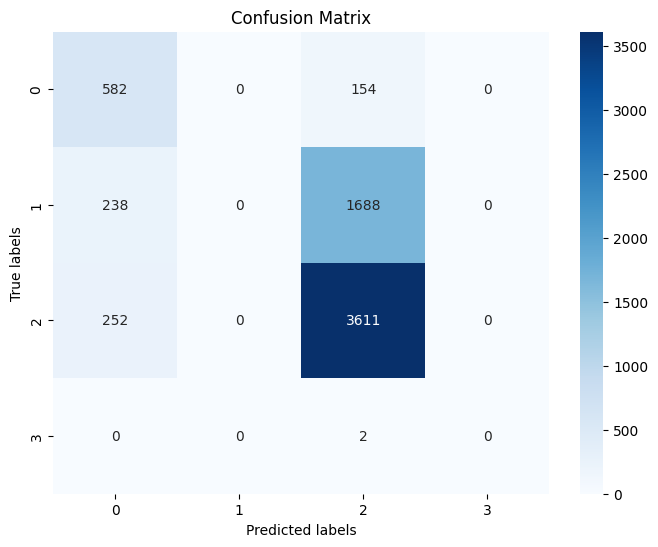

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred_probs = model.predict(X_test_pad)
y_pred = y_pred_probs.argmax(axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


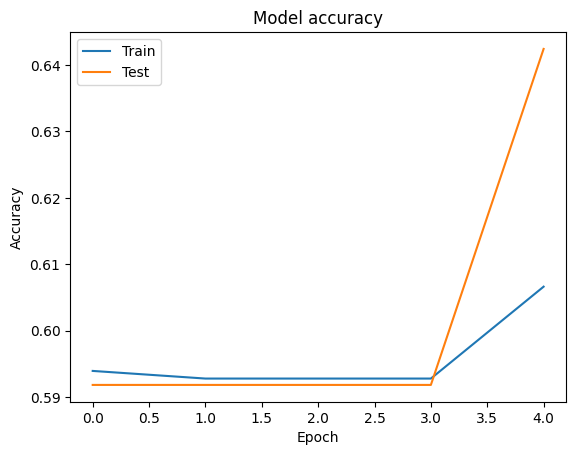

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


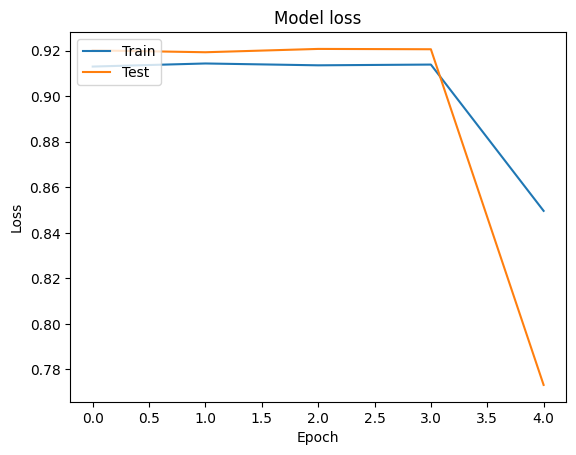

In [14]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data["Processed_Text"], data["Labels"], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Make predictions
y_pred = model.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8535314846024207

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       736
           1       0.85      0.70      0.77      1926
           2       0.85      0.94      0.89      3863
           3       0.00      0.00      0.00         2

    accuracy                           0.85      6527
   macro avg       0.64      0.61      0.63      6527
weighted avg       0.85      0.85      0.85      6527



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
